<a href="https://colab.research.google.com/github/mazinkamal134/DS_MRP_2024/blob/main/Demographics%20Pipeline/Demographics_Gender_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 17.8 MB/s eta 0:00:00


### Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import html
import pickle
import contractions
import emoji

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Word Embeddings
from gensim.models import KeyedVectors  # For loading GloVe embeddings
from gensim.scripts.glove2word2vec import glove2word2vec  # For converting GloVe embeddings to Word2Vec format

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global Params

In [ ]:
ssaDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics/SSA"
authorsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Authors"
tweetsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Tweets"
embeddingDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics/Word Embeddings"
demographicsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics"

### Text Cleaning

In [ ]:
# Function to preprocess the text
def clean_text(text):
    if text is None: # Check if text is None
      return "" # Return empty string if None

    # regex
    JUST_WORDS = re.compile(r"\W+")
    SLASHES = re.compile(r"[\\/]")
    PERCENT = re.compile(r"[%]")
    URLs = re.compile(r"http\S+|www\S+|https\S+")
    HASHTAG = re.compile(r"#\w+")
    EMOJIS = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002500-\U00002BEF"  # Other symbols
        "\U0001F004"             # Mahjong Tile Red Dragon
        "\U0001F0CF"             # Playing Card Black Joker
        "\U0001F018-\U0001F270"  # Various Asian characters
        "\U0001F201-\U0001F251"  # Enclosed characters
        "\U0001F926-\U0001F937"  # Additional emoji
        "\U0001F97C-\U0001F9FF"  # Additional emoji
        "\U0001F9E0-\U0001F9E6"  # Additional emoji
        "\U0001F680-\U0001F6C5"  # Transport and map symbols
        "\U0001F6F4-\U0001F6F8"  # Additional transport and map symbols
        "\U0001F7E0-\U0001F7EB"  # Additional symbols
        "\U0001F90D-\U0001F93A"  # Additional emoji
        "\U0001F93C-\U0001F945"  # Additional emoji
        "\U0001F947-\U0001F978"  # Additional emoji
        "\U0001F97A-\U0001F9CB"  # Additional emoji
        "\U0001F9CD-\U0001FA6D"  # Additional emoji
        "\U0001FA60-\U0001FA6D"  # Additional emoji
        "\U0001FA70-\U0001FA74"  # Additional emoji
        "\U0001FA78-\U0001FA7A"  # Additional emoji
        "\U0001FA80-\U0001FA86"  # Additional emoji
        "\U0001FA90-\U0001FAA8"  # Additional emoji
        "\U0001FAB0-\U0001FAB6"  # Additional emoji
        "\U0001FAC0-\U0001FAC2"  # Additional emoji
        "\U0001FAD0-\U0001FAD6"  # Additional emoji
        "\u200d"                 # Zero Width Joiner
        "\u2640-\u2642"          # Gender symbols
        "\u2600-\u2B55"          # Miscellaneous symbols and dingbats
        "\u23cf"                 # Eject symbol
        "\u23e9"                 # Fast forward
        "\u231a"                 # Watch
        "\ufe0f"                 # Dingbats
        "\u3030"                 # Wavy dash
        "\u00a9"                 # Copyright
        "\u00ae"                 # Registered
        "\u2122"                 # Trademark
        "]+", flags = re.UNICODE)

    # Replace contractions with their original form
    text = contractions.fix(text)
    # remove html related
    text = html.unescape(text)
    # remove the line feeds
    text = re.sub(r"\n", " ", text)
    # lowercase text
    text = text.lower()
    # Remove emojis from the text using the pattern
    text = EMOJIS.sub(" ", text)
    # Substitute the matched string in URLs with space.
    text = URLs.sub(" ", text)
    # Substitute the matched string in HASHTAG with space.
    text = HASHTAG.sub(" ", text)
    # Substitute the matched string in SLASHES with space.
    text = SLASHES.sub(" ", text)
    # Replace % (this is specific to the Java API)
    text = re.sub(r'%', " percent", text)
    # Remove what's left
    text = JUST_WORDS.sub(" ", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Trim the text
    text = text.strip()

    return text

### Gender Inference

#### Token-based Gender Inferences from User Description

In [ ]:
# Define lists of gender-identifying tokens
femaleTokens = [
    'girl', 'woman', 'lady', 'female', 'she', 'her', 'hers', 'queen', 'mother', 'daughter',
    'sister', 'wife', 'aunt', 'niece', 'actress', 'waitress', 'stewardess', 'bride', 'mom',
    'girlfriend', 'fiancée', 'fiancee', 'princess', 'ms', 'mrs'
]
maleTokens = [
    'boy', 'man', 'guy', 'gentleman', 'male', 'he', 'him', 'his', 'king', 'father', 'son', 'brother',
    'husband', 'uncle', 'nephew', 'actor', 'waiter', 'steward', 'groom', 'dad', 'boyfriend',
    'fiancé', 'fiance', 'prince', 'mr'
]

# Function to identify gender from description
def identify_gender_from_tokens(text):
    # Tokenize
    tokenized = word_tokenize(text)
    # Count matching tokens
    femaleTokensCnt = sum(token in tokenized for token in femaleTokens)
    maleTokensCnt = sum(token in tokenized for token in maleTokens)
    # Assign
    if femaleTokensCnt > maleTokensCnt:
        return 'Female'
    elif maleTokensCnt > femaleTokensCnt:
        return 'Male'
    else:
        return None

#### US Social Security Administration (SSA) Baby Names

In [ ]:
path = ssaDir
files = os.listdir(path)
firstFile = files[0]
year = firstFile[3:7]
babyNamesDf = pd.read_csv(os.path.join(path, firstFile), header = None, names = ["name", "gender", "count"])
babyNamesDf["year"] = year

for i in range(1, len(files)):
    # Consume the data
    df = pd.read_csv(os.path.join(path, files[i]), header = None, names = ["name", "gender", "count"])
    df["year"] = files[i][3:7]
    # Add to the original dataframe
    babyNamesDf = pd.concat([babyNamesDf, df])

# Sort
babyNamesDf.sort_values(by = ["name", "year", "gender"], inplace = True)

# Group by name, and gender, sum count
babyNamesGrouped = pd.DataFrame(babyNamesDf.groupby(["name", "gender"])["count"].sum()).reset_index()

# Pivot
babyNamesPivoted = babyNamesGrouped.pivot(index = "name", columns = "gender", values = "count").reset_index()

# Fill na with 0
babyNamesPivoted.fillna(0, inplace = True)

# Add two new probability columns
babyNamesPivoted["F_prob"] = babyNamesPivoted.apply(lambda row: row["F"]/(row["F"] + row["M"]), axis = 1)
babyNamesPivoted["M_prob"] = babyNamesPivoted.apply(lambda row: row["M"]/(row["F"] + row["M"]), axis = 1)
babyNamesDf = babyNamesPivoted[["name", "F_prob", "M_prob"]]

print("Baby names shape:", babyNamesDf.shape)

# Remove the confusing names (prob < 0.8)
babyNamesDf[(babyNamesDf.F_prob < 0.8) & (babyNamesDf.M_prob < 0.8)]
print("Baby names shape after removing confusing names:", babyNamesDf.shape)

# Select Gender based on prob
babyNamesDf["sex"] = babyNamesDf.apply(lambda row: "Female" if row["F_prob"] > row["M_prob"] else "Male", axis = 1)

# Create a search dictionary
namedDict = dict(babyNamesDf[["name", "sex"]].values)

Baby names shape: (103564, 3)
Baby names shape after removing confusing names: (103564, 3)


<ipython-input-8-20c5b31cdd94>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  babyNamesDf["sex"] = babyNamesDf.apply(lambda row: "Female" if row["F_prob"] > row["M_prob"] else "Male", axis = 1)


In [ ]:
def identify_gender_from_first_name(name):
    # Get the 1st name
    if name != "" and name != None:
        name = name.split()[0].strip()
    # Capitalize the first letter of the name
    name = name.capitalize()

    # Look up the name in the gender dictionary
    gender = namedDict.get(name)

    return gender

#### Import the users data

In [ ]:
# Read the data
usersDf = pd.read_parquet(os.path.join(authorsDir, "Authors.parquet"))

# Clean the required text
usersDf["description_cleaned"] = usersDf["description"].apply(clean_text)
usersDf["name_cleaned"] = usersDf["name"].apply(clean_text)

"""
controlUsers = pd.read_csv(os.path.join(authorsDir, "authors_control.csv"))
# Add the group column
controlUsers["group"] = 0
print("Control users shape:", controlUsers.shape)
treatmentUsers = pd.read_csv(os.path.join(authorsDir, "authors_treatment.csv"))
treatmentUsers["group"] = 1
print("Treatment users shape:", treatmentUsers.shape)

# Combine
usersDf = pd.concat([controlUsers, treatmentUsers])

# Remove the unnecessary columns
usersDf.drop(["anonymized_id", "matched_author_count", "matched_author_ids", "location", "username"], axis = 1, inplace = True)

# Fix the datatypes
usersDf["created_at"] = pd.to_datetime(usersDf["created_at"]).dt.tz_localize(None)
# find the account age
usersDf["account_age"] = (pd.to_datetime("today") - usersDf["created_at"]).dt.days/365.0
# Fill na
usersDf["account_age"].fillna(0, inplace = True)
toFill = ["followers_count", "following_count", "tweet_count"]
# Fill and convert to int
usersDf[toFill] = usersDf[toFill].fillna(0)
usersDf["followers_count"] = usersDf["followers_count"].astype("int64")
usersDf["following_count"] = usersDf["following_count"].astype("int64")
usersDf["tweet_count"] = usersDf["tweet_count"].astype("int64")

# Fill the rest of columns with nothing
usersDf.fillna("", inplace = True)

# Clean the required text
usersDf["description_cleaned"] = usersDf["description"].apply(clean_text)
# find the length of the description field
usersDf["description_len"] = usersDf["description"].apply(lambda x: len(x.split()))
usersDf["name_cleaned"] = usersDf["name"].apply(clean_text)

# Reorganize the columns
reOrg = ['id', 'created_at', "account_age", 'verified', 'name', 'name_cleaned', 'description',
       'description_cleaned', "description_len", 'disorder', 'group', 'followers_count', 'following_count', 'tweet_count']
usersDf = usersDf[reOrg]
# Rename id to author_id
usersDf.rename({"id":"author_id"}, axis = 1, inplace = True)
# Change the author_id data type to str
usersDf["author_id"] = usersDf["author_id"].astype("str")
"""
# Check
print("Full dataset shape:", usersDf.shape)

#### Assign the inferred gender

In [ ]:
# Function to select the gender from infrred values
def select_inferred_gender(genderFromDesc, genderFromName, genderFromPron):
    if genderFromName is not None:
        return genderFromName
    if genderFromPron is not None:
        return genderFromPron
    elif genderFromDesc is not None:
        return genderFromDesc
    else:
        return "Unknown"

In [ ]:
# Infer gender based on description
usersDf["gender_from_desc"] = usersDf["description_cleaned"].apply(identify_gender_from_tokens)
# Infer gender from first name
usersDf["gender_from_name"] = usersDf["name_cleaned"].apply(identify_gender_from_first_name)
# Infer gender from pronouns mentioned in the name
usersDf["gender_from_pron"] = usersDf["name_cleaned"].apply(identify_gender_from_tokens)
# Combine (name inference takes precedence)
usersDf["gender"] = usersDf.apply(lambda row: select_inferred_gender(row["gender_from_desc"], row["gender_from_name"], row["gender_from_pron"]), axis = 1)

In [ ]:
# Report
print("Unknowns:", usersDf[usersDf.gender == "Unknown"].shape[0])
# By gender
pd.DataFrame(usersDf.groupby(["group", "gender"])["gender"].count()).rename({"gender":"Count"}, axis = 1).reset_index().pivot(index = "group", columns = "gender", values = "Count")

Unknowns: 1836


gender,Female,Male,Unknown
group,,,
0,1515,1000,1242
1,728,533,594


### Feature Engineering

#### Preprocess Tweets

In [ ]:
# Load the tweets parquet file
tweetsDf = pd.read_parquet(os.path.join(tweetsDir, "processedTweets.parquet"))
print("Original tweets shape:", tweetsDf.shape)
# Remove other languages + remove the missing text, and only focus on original timeline tweets
# Commented part is to account for some control users without timeline tweets
tweetsDf = tweetsDf[(tweetsDf.cleaned_text.notna()) &
 #(tweetsDf.tweet_type == "timeline") &
  #(tweetsDf.referenced_tweet_type != "quoted") &
   (tweetsDf.lang == "en")]
# Join with the users
tweetsDf = tweetsDf.merge(usersDf[["author_id"]], on = "author_id", how = "inner")
print("Filtered tweets shape:", tweetsDf.shape)

# Sort by author_id and created_at for further processing
tweetsDf = tweetsDf.sort_values(by = ["author_id", "created_at"], ascending = [True, False])
print("Tweets shape:", tweetsDf.shape)

Original tweets shape: (15542629, 28)
Filtered tweets shape: (8025384, 28)
Tweets shape: (8025384, 28)


#### Tweets features
Aggregation at user level

In [ ]:
# Function to extract some tweet features
def extract_tweet_features(text):
    hashtag_pattern = r"#\w+"
    url_pattern = r"https?://\S+"
    mention_pattern = r"@\w+"

    hashtag_count = len(re.findall(hashtag_pattern, text))
    url_count = len(re.findall(url_pattern, text))
    mention_count = len(re.findall(mention_pattern, text))

    return {
        "hashtag_count": hashtag_count,
        "url_count": url_count,
        "mention_count": mention_count
    }

# Update the dataframe
tweetsDf["tweet_features"] = tweetsDf["cleaned_text"].apply(extract_tweet_features)
# Split the tweet_features into 3 different coloumns
tweetsDf[["auth_hashtag_count", "auth_url_count", "auth_mention_count"]] = pd.DataFrame(tweetsDf["tweet_features"].tolist(), index = tweetsDf.index)

# Find total number of tokens per tweet
tweetsDf["total_tokens"] = tweetsDf["cleaned_text"].apply(lambda x: len(x.split()))

# Fill na
tweetsDf["auth_hashtag_count"].fillna(0, inplace = True)
tweetsDf["auth_url_count"].fillna(0, inplace = True)
tweetsDf["auth_mention_count"].fillna(0, inplace = True)

# Aggregate at user level
engagementMetricsDf = tweetsDf.groupby("author_id").agg({
    "auth_hashtag_count": "sum",
    "auth_url_count": "sum",
    "auth_mention_count": "sum",
    "like_count": "sum",
    "retweet_count": "sum",
    "reply_count": "sum",
    "quote_count": "sum",
    "total_tokens": "mean"
}).reset_index().rename({"like_count": "auth_like_count", "retweet_count": "auth_retweet_count", "reply_count": "auth_reply_count", "quote_count": "auth_quote_count", "total_tokens": "auth_avg_tokens"}, axis = 1)

# Drop the unnecessary columns
tweetsDf.drop(["tweet_features", "auth_hashtag_count", "auth_url_count", "auth_mention_count"], axis = 1, inplace = True)

# Combine with the userDf
usersDf = usersDf.merge(engagementMetricsDf, on = "author_id", how = "left")

#### Time features
Aggregations at the user level

In [ ]:
# Popular Posting Time (Categorical):
def categorize_time(hour):
    if 5 <= hour < 12:
        return "Early Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 22:
        return "Evening"
    elif 22 <= hour or hour < 5:  # Covers late night and after midnight
        return "Night"

# Aggregate by majority vote
def aggregate_by_majority_vote(group):
    modeResult = group.mode()
    return modeResult.iloc[0] if not modeResult.empty else None

tweetsDf['posting_time'] = tweetsDf['created_at'].dt.hour.apply(categorize_time)

# Average Time Between Tweets (per User):
tweetsDf['time_since_last_tweet'] = tweetsDf.sort_values(['author_id', 'created_at']).groupby('author_id')['created_at'].diff()

meanTimeBetweenTweets = tweetsDf.groupby('author_id')['time_since_last_tweet'].mean().dt.total_seconds() / 3600
meanTimeBetweenTweets = meanTimeBetweenTweets.reset_index(name = "mean_time_between_tweets")
# Fill null values
meanTimeBetweenTweets['mean_time_between_tweets'].fillna(0, inplace = True)
# drop the unnecessary column
tweetsDf.drop(columns = ["time_since_last_tweet"], inplace = True)

# Posting Day of Week (Categorical) and Weekend vs. Weekday (Binary):
tweetsDf['day_of_week'] = tweetsDf['created_at'].dt.day_name()

# Tweet Frequency (per User):
tweetFrequency = tweetsDf['author_id'].value_counts() / (tweetsDf['created_at'].max() - tweetsDf['created_at'].min()).days
tweetFrequency = tweetFrequency.reset_index(name = "tweet_frequency")

# Apply majority voting to each categorical feature
postingTime = tweetsDf.groupby('author_id')['posting_time'].apply(aggregate_by_majority_vote).reset_index()
dayOfWeek = tweetsDf.groupby('author_id')['day_of_week'].apply(aggregate_by_majority_vote).reset_index()

# Combine aggregated features into a single DataFrame
timeFeaturesPerUser = pd.DataFrame({
    'author_id': postingTime['author_id'],
    'fav_posting_time': postingTime['posting_time'],
    'fav_day_of_week': dayOfWeek['day_of_week'],
    "mean_time_between_tweets": meanTimeBetweenTweets['mean_time_between_tweets'],
    "tweet_frequency": tweetFrequency['tweet_frequency']
})

# merge back into the original tweets DataFrame
usersDf = usersDf.merge(timeFeaturesPerUser, on = 'author_id', how = 'left')

# Fill the na
mostFavPostingDay = usersDf.fav_day_of_week.value_counts().reset_index(name = "count").iloc[0]["fav_day_of_week"]
mostFavPostingTime = usersDf.fav_posting_time.value_counts().reset_index(name = "count").iloc[0]["fav_posting_time"]
usersDf = usersDf.fillna({"fav_day_of_week": mostFavPostingDay, "fav_posting_time": mostFavPostingTime})
# Use the fav_day_of_week to infer the weekend day
usersDf["is_weekend"] = usersDf.fav_day_of_week.isin(["Saturday", "Sunday"])

#### Most Recent Tweets

In [ ]:
# Get only the last n tweets of each user based on created_at and combine at user level
n = 200
recentTweetsDf = tweetsDf.groupby("author_id").head(n).reset_index()

# Aggregate on the last n tweets for each user
authorsWithTextDf = recentTweetsDf.groupby("author_id")["cleaned_text"].apply(lambda x: ". ".join(x)).reset_index()

# Add the lexical density for the tweets
authorsWithTextDf["lexical_density"] = authorsWithTextDf["cleaned_text"].apply(lambda x: len(set(x.split())) / len(x.split()))

# Duplicate the text column
authorsWithTextDf["original_text"] = authorsWithTextDf["cleaned_text"]
# Clean the aggregated tweets of each author
authorsWithTextDf["cleaned_text"] = authorsWithTextDf["cleaned_text"].apply(clean_text)

# Join with the usersDf on author_id
authorsWithTextDf = authorsWithTextDf.merge(usersDf[["author_id", "verified", "description_len", "account_age",
                                                     "followers_count", "following_count", "tweet_count",
                                                     "fav_posting_time", "fav_day_of_week", "mean_time_between_tweets", "tweet_frequency", "is_weekend",
                                                     "auth_hashtag_count", "auth_url_count", "auth_mention_count", "auth_like_count", "auth_retweet_count", "auth_reply_count", "auth_quote_count", "auth_avg_tokens",
                                                     "gender"]], on = "author_id", how = "inner")

print("Authors with text shape:", authorsWithTextDf.shape)

Authors with text shape: (5612, 24)


#### Linguistic features

In [ ]:
# Function to get POS tag counts for a tweet
def get_pos_tag_counts(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    tag_counts = {}
    for word, tag in tagged_tokens:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

# Apply the function to the 'cleaned_text' column
authorsWithTextDf['pos_tag_counts'] = authorsWithTextDf['cleaned_text'].astype(str).apply(get_pos_tag_counts)

# Define lists of relevant tags for each category
nouns = ['NN', 'NNS', 'NNP', 'NNPS']
verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adjectives = ['JJ', 'JJR', 'JJS']
adverbs = ['RB', 'RBR', 'RBS']

# Count tags in a specific category
def count_tags(counts, tags):
    return sum(counts.get(tag, 0) for tag in tags)

# Create new columns for each part of speech
authorsWithTextDf["noun_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, nouns))
authorsWithTextDf["verb_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, verbs))
authorsWithTextDf["adjective_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, adjectives))
authorsWithTextDf["adverb_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, adverbs))
# Create a column for other tags
all_tags = nouns + verbs + adjectives + adverbs
authorsWithTextDf['other_tags'] = authorsWithTextDf['pos_tag_counts'].apply(lambda x: sum(count for tag, count in x.items() if tag not in all_tags))

#### Emoji's

In [ ]:
# Extract emojis from a tweet
def extract_emojis(text):
    return [c for c in text if c in emoji.EMOJI_DATA]

# Count emojis in a tweet
def count_emojis(text):
    return len(extract_emojis(text))

# Get sentiment of emojis in a tweet (using demojize and VADER)
sia = SentimentIntensityAnalyzer()
def emoji_sentiment(text):
    emoji_descriptions = " ".join([emoji.demojize(c) for c in extract_emojis(text)])
    return sia.polarity_scores(" ".join(emoji_descriptions.replace(":", "").split("_")))["compound"]

# Apply the functions to the 'cleaned_text' column
authorsWithTextDf["emojis"] = authorsWithTextDf["original_text"].apply(extract_emojis)
authorsWithTextDf["emoji_count"] = authorsWithTextDf["original_text"].apply(count_emojis)
authorsWithTextDf["emoji_sentiment"] = authorsWithTextDf["original_text"].apply(emoji_sentiment)

# Drop unnecessary columns
authorsWithTextDf.drop(["original_text", "pos_tag_counts", "emojis"], axis = 1, inplace = True)

In [ ]:
# Validate
authorsWithTextDf.gender.value_counts()

,count
gender,
Female,2243
Unknown,1836
Male,1533


#### Data balancing

In [ ]:
# Balance the dataset for model training
rus = RandomUnderSampler(random_state = 42)
# Split the data into features and target
X = authorsWithTextDf[authorsWithTextDf.gender != "Unknown"]
X.drop(columns=["author_id", "gender"], inplace=True)
featureNames = X.columns.tolist()
y = authorsWithTextDf[authorsWithTextDf.gender != "Unknown"]["gender"]

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X, y)
X = pd.DataFrame(X_resampled, columns = featureNames)
y = pd.Series(y_resampled)

# Categorize
X["fav_posting_time"] = X["fav_posting_time"].astype("category").cat.codes
X["fav_day_of_week"] = X["fav_day_of_week"].astype("category").cat.codes
X["is_weekend"] = X["is_weekend"].astype("bool")

# Unify the undersampled dataframe
undersampledDf = pd.concat([X, y], axis = 1).reset_index(drop = True)
print("Shape of the ML df:", undersampledDf.shape)

# Subject dataframe (will be used throught the section)
X = undersampledDf[undersampledDf.gender.notna()].reset_index(drop = True)
X.drop(columns=["gender"], inplace=True)

Shape of the ML df: (3066, 29)


<ipython-input-25-1c1f9a1a26e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=["author_id", "gender"], inplace=True)


#### TF-IDF

In [ ]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features = 10000, ngram_range = (1, 2), min_df = 0.05, max_df = 0.95, stop_words = "english")
X_tfidf = vectorizer.fit_transform(X["cleaned_text"])

# Create a DataFrame from the TF-IDF matrix
tfidfDf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
tfidfFeatures = tfidfDf.columns.tolist()
# Check
print("TF-IDF shape:", tfidfDf.shape)

TF-IDF shape: (3066, 2876)


#### Embeddings

In [ ]:
# Load pre-trained GloVe embeddings for Twitter (adjust path if needed)
gloveFilePath = os.path.join(embeddingDir, "glove.twitter.27B.25d.txt")
tempFile = "temp_word2vec.txt"

# Convert GloVe to Word2Vec format (required for loading with Gensim)
glove2word2vec(gloveFilePath, tempFile)

# Load the converted embeddings
gloveModel = KeyedVectors.load_word2vec_format(tempFile, binary=False)

# Function to get GloVe representation of a tweet
def get_tweet_embedding(text):
    words = text.split()
    validWords = [word for word in words if word in gloveModel]
    if validWords:
        return np.mean(gloveModel[validWords], axis=0)
    else:
        return np.zeros(gloveModel.vector_size)

# Create GloVe embeddings for tweets
embeddings = X["cleaned_text"].apply(get_tweet_embedding)
# Convert to dataframe
embeddingDf = pd.DataFrame(embeddings.tolist(), columns = [f"embedding_{i}" for i in range(gloveModel.vector_size)])
# Get the feature names
embeddingFeatures = embeddingDf.columns.tolist()
# Check
print("Embeddings shape:", embeddingDf.shape)

<ipython-input-27-e2a5713482d7>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(gloveFilePath, tempFile)


Embeddings shape: (3066, 25)


#### PCA

In [ ]:
# Separate Features (X) and Labels (y)
X = undersampledDf.drop(columns = ["cleaned_text"])  # Exclude non-numeric columns
y = undersampledDf['gender']

# Identify numerical columns
#numericalCols = X.select_dtypes(include=np.number).columns.tolist()
categoricalCols = ['fav_posting_time', 'fav_day_of_week']
numericalCols = ['verified', 'lexical_density', 'description_len', 'account_age',
                'followers_count', 'following_count', 'tweet_count',
                'mean_time_between_tweets', 'tweet_frequency', 'is_weekend',
                'auth_hashtag_count', 'auth_url_count', 'auth_mention_count', 'auth_like_count', 'auth_retweet_count', 'auth_reply_count', 'auth_quote_count', 'auth_avg_tokens',
                'noun_tags', 'verb_tags', 'adjective_tags', 'adverb_tags', 'other_tags',
                'emoji_count', 'emoji_sentiment']

# Create a ColumnTransformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalCols),   # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categoricalCols), # One-hot encode categorical features
    ])

# Create a PCA pipeline:
pca = PCA()

# Combine preprocessing and PCA into a single pipeline:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])

# Fit the pipeline to the data:
pipeline.fit(X)

# Get explained variance ratios
explainedVarRatio = pca.explained_variance_ratio_

# Determine the number of components to keep
cumulativeVarRatio = np.cumsum(explainedVarRatio)
nComponents = np.argmax(cumulativeVarRatio >= 0.95) + 1  # Keep components explaining 95% variance

# Transform the data using the selected number of components
X_pca = pipeline.transform(X)[:, :nComponents]

# Create a DataFrame for the transformed data
pcaFeatures = [f'PC{i+1}' for i in range(nComponents)]
pcaDf = pd.DataFrame(X_pca, columns = pcaFeatures, index = X.index)

# Check
print("Embeddings shape:", pcaDf.shape)

Embeddings shape: (3066, 21)


#### Decomposed TF-IDF

In [ ]:
# Apply SVD (TruncatedSVD for sparse matrices)
svd = TruncatedSVD(n_components = 100)
svdResult = svd.fit_transform(X_tfidf)

# Create DataFrame with SVD results and original feature names
svdTfidfDf = pd.DataFrame(svdResult, columns=[f"svd_tfidf_{i}" for i in range(svdResult.shape[1])])

# Get the feature names
svdTfidfFeatures = svdTfidfDf.columns.tolist()
# Check
print("TF-IDF shape:", svdTfidfDf.shape)

TF-IDF shape: (3066, 100)


#### Metadata

In [ ]:
# Create a ColumnTransformer to preprocess the data
categoricalCols = ['fav_posting_time', 'fav_day_of_week']
numericalCols = ['verified', 'lexical_density', 'description_len', 'account_age',
                'followers_count', 'following_count', 'tweet_count',
                'mean_time_between_tweets', 'tweet_frequency', 'is_weekend',
                'auth_hashtag_count', 'auth_url_count', 'auth_mention_count', 'auth_like_count', 'auth_retweet_count', 'auth_reply_count', 'auth_quote_count', 'auth_avg_tokens',
                'noun_tags', 'verb_tags', 'adjective_tags', 'adverb_tags', 'other_tags',
                'emoji_count', 'emoji_sentiment']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalCols),   # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categoricalCols), # One-hot encode categorical features
    ])

processed = preprocessor.fit_transform(X)
metadataDf = pd.DataFrame(processed, columns = preprocessor.get_feature_names_out())
metadataFeatures = metadataDf.columns.tolist()
# Check
print("Metadata shape:", metadataDf.shape)

Metadata shape: (3066, 36)


#### Combine Features

In [ ]:
# Get y and label encode it
y = undersampledDf[undersampledDf.gender.notna()]["gender"]
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), name="label")
classes = le.classes_

# Calculate scale_pos_weight
imbalanceRatio = y.value_counts()[0] / y.value_counts()[1]
print("Imbalance Ratio:", imbalanceRatio)

# Concatenate all features
finalMLDf = pd.concat([metadataDf, tfidfDf, embeddingDf, pcaDf, svdTfidfDf, y], axis = 1)
print("Final ML shape:", finalMLDf.shape)

Imbalance Ratio: 1.0
Final ML shape: (3066, 3059)


### Machine Learning

In [ ]:
# Split the data into features and target
X = finalMLDf.drop(columns = ["label"])
y = finalMLDf["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Reset the index for the next step
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# Unify the dataframes
trainDf = pd.concat([X_train, y_train], axis = 1)
testDf = pd.concat([X_test, y_test], axis = 1)

# Check
print("Shape of the train df:", trainDf.shape)
print("Shape of the test df:", testDf.shape)
print("Labels on train:", trainDf.label.value_counts())
print("Labels on test:", testDf.label.value_counts())

Shape of the train df: (2452, 3059)
Shape of the test df: (614, 3059)
Labels on train: label
1    1237
0    1215
Name: count, dtype: int64
Labels on test: label
0    318
1    296
Name: count, dtype: int64


#### Metadata

In [ ]:
# Create StratifiedKFold object for balanced folds
k = 10
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# Train an XGBoost model
xgb_model_meta = xgb.XGBClassifier(objective='binary:logistic', max_depth = 3, subsample = 0.8, colsample_bytree = 0.8, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train the model on the fold
  xgb_model_meta.fit(X_train_fold[metadataFeatures], y_train_fold)

  # Make predictions on the validation set
  y_pred_fold = xgb_model_meta.predict(X_val_fold[metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_meta, X_train[metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfMeta = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfMeta)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train the model on the full training set
xgb_model_meta.fit(X_train[metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_meta.predict(X_test[metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.5832
Std. Dev: 0.0283
All accuracy values:  [0.622 0.602 0.6   0.559 0.539 0.592 0.535 0.58  0.592 0.612]
Average ROC-AUC: 0.6155
Folds avg. metrics:
      metric    Female      Male
0   f1-score  0.574835  0.589873
1  precision  0.579853  0.587643
2     recall  0.572043  0.594211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.5700
Classification Report:
               precision    recall  f1-score   support

      Female       0.59      0.53      0.56       318
        Male       0.55      0.61      0.58       296

    accuracy                           0.57       614
   macro avg       0.57      0.57      0.57       614
weighted avg       0.57      0.57      0.57       614

Confusion Matrix:
 [[170 148]
 [116 180]]


In [ ]:
reportsDfMeta.round(3)

,metric,Female,Male
0,f1-score,0.575,0.590
1,precision,0.580,0.588
2,recall,0.572,0.594


##### ROC

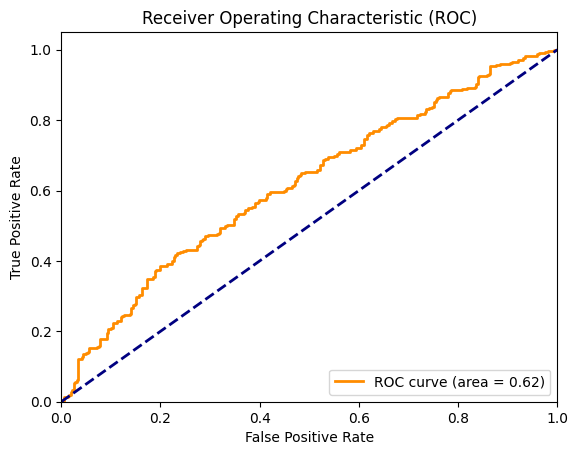

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_meta.predict_proba(X_test[metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### PCA

In [ ]:
k = 10
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# Train XGBoost model on PCA features
xgb_model_pca = xgb.XGBClassifier(objective='binary:logistic', max_depth = 3, subsample = 0.8, colsample_bytree = 0.8, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_pca.fit(X_train_fold[pcaFeatures], y_train_fold)

  # Make predictions
  y_pred_fold = xgb_model_pca.predict(X_val_fold[pcaFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_pca, X_train[pcaFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfPca = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfPca)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on full training set
xgb_model_pca.fit(X_train[pcaFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_pca.predict(X_test[pcaFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.5702
Std. Dev: 0.0277
All accuracy values:  [0.537 0.565 0.571 0.563 0.514 0.559 0.604 0.592 0.604 0.592]
Average ROC-AUC: 0.6007
Folds avg. metrics:
      metric    Female      Male
0   f1-score  0.558594  0.579472
1  precision  0.569053  0.572085
2     recall  0.550684  0.589326
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.5749
Classification Report:
               precision    recall  f1-score   support

      Female       0.61      0.48      0.54       318
        Male       0.55      0.68      0.61       296

    accuracy                           0.57       614
   macro avg       0.58      0.58      0.57       614
weighted avg       0.58      0.57      0.57       614

Confusion Matrix:
 [[153 165]
 [ 96 200]]


In [ ]:
reportsDfPca.round(3)

,metric,Female,Male
0,f1-score,0.559,0.579
1,precision,0.569,0.572
2,recall,0.551,0.589


##### ROC

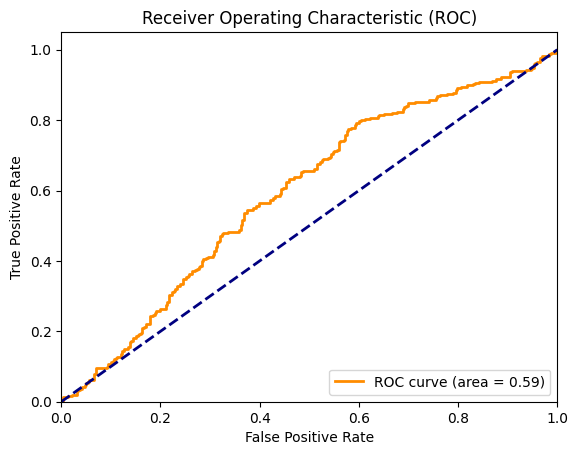

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_pca.predict_proba(X_test[pcaFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### TF-IDF

In [ ]:
k = 10
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model
xgb_model_tfidf = xgb.XGBClassifier(objective='binary:logistic', max_depth = 3, subsample = 0.8, colsample_bytree = 0.8, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_tfidf.fit(X_train_fold[tfidfFeatures + metadataFeatures], y_train_fold)

  # Make predictions on the test set
  y_pred_fold = xgb_model_tfidf.predict(X_val_fold[tfidfFeatures + metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_tfidf, X_train[tfidfFeatures + metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfTfidf = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfTfidf)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on full training set
xgb_model_tfidf.fit(X_train[tfidfFeatures + metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_tfidf.predict(X_test[tfidfFeatures + metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.6268
Std. Dev: 0.0221
All accuracy values:  [0.622 0.602 0.612 0.62  0.624 0.596 0.62  0.661 0.665 0.645]
Average ROC-AUC: 0.6811
Folds avg. metrics:
      metric    Female      Male
0   f1-score  0.630591  0.622364
1  precision  0.619041  0.636000
2     recall  0.643653  0.610379
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.6482
Classification Report:
               precision    recall  f1-score   support

      Female       0.65      0.68      0.67       318
        Male       0.64      0.61      0.63       296

    accuracy                           0.65       614
   macro avg       0.65      0.65      0.65       614
weighted avg       0.65      0.65      0.65       614

Confusion Matrix:
 [[217 101]
 [115 181]]


In [ ]:
reportsDfTfidf.round(3)

,metric,Female,Male
0,f1-score,0.631,0.622
1,precision,0.619,0.636
2,recall,0.644,0.610


##### ROC

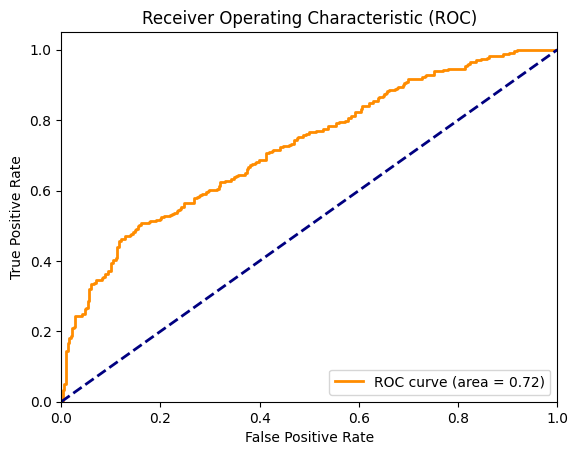

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_tfidf.predict_proba(X_test[tfidfFeatures + metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### TF-IDF + SVD
with PCs of the Metadata

In [ ]:
k = 10
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on TF-IDF features
xgb_model_tfidf_svd = xgb.XGBClassifier(objective='binary:logistic', max_depth = 3, subsample = 0.8, colsample_bytree = 0.8, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_tfidf_svd.fit(X_train_fold[svdTfidfFeatures + pcaFeatures], y_train_fold)

  # Make predictions on the test set
  y_pred_fold = xgb_model_tfidf_svd.predict(X_val_fold[svdTfidfFeatures + pcaFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_tfidf_svd, X_train[svdTfidfFeatures + pcaFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfSvd = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfSvd)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on full training set
xgb_model_tfidf_svd.fit(X_train[svdTfidfFeatures + pcaFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_tfidf_svd.predict(X_test[svdTfidfFeatures + pcaFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.6415
Std. Dev: 0.0352
All accuracy values:  [0.602 0.659 0.665 0.641 0.69  0.633 0.567 0.669 0.669 0.62 ]
Average ROC-AUC: 0.6977
Folds avg. metrics:
      metric    Female      Male
0   f1-score  0.647506  0.635117
1  precision  0.631280  0.653108
2     recall  0.664964  0.618489
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.6629
Classification Report:
               precision    recall  f1-score   support

      Female       0.67      0.68      0.68       318
        Male       0.65      0.65      0.65       296

    accuracy                           0.66       614
   macro avg       0.66      0.66      0.66       614
weighted avg       0.66      0.66      0.66       614

Confusion Matrix:
 [[216 102]
 [105 191]]


In [ ]:
X_train[svdTfidfFeatures + pcaFeatures].head()

,svd_tfidf_0,svd_tfidf_1,svd_tfidf_2,svd_tfidf_3,svd_tfidf_4,svd_tfidf_5,svd_tfidf_6,svd_tfidf_7,svd_tfidf_8,svd_tfidf_9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0.529103,0.034657,-0.080549,0.024099,-0.008324,-0.097118,0.015870,0.080168,-0.054870,-0.005957,...,-0.186993,-0.319536,-0.126244,-0.177389,-0.165276,-0.435065,0.901772,-0.408547,-0.136443,-0.515958
1,0.548564,-0.070137,0.000715,0.038426,0.069861,-0.030247,-0.088336,0.189576,-0.066293,-0.005606,...,0.128485,-0.469421,0.035092,-1.323059,0.524077,-1.624615,0.763853,0.503823,0.193021,0.643488
2,0.209635,-0.158014,0.046180,0.021127,-0.011224,-0.071328,-0.013083,-0.110855,0.026264,0.006803,...,-0.232571,0.480011,0.170633,0.322107,1.049582,0.255362,0.517925,-0.061138,0.253253,0.821755
3,0.494172,-0.216542,0.092050,0.054307,-0.072532,-0.071423,0.004078,-0.026330,0.013070,0.001926,...,-0.290266,0.739890,0.349989,0.504809,0.482396,0.573680,-0.625749,0.270540,0.681821,-0.462878
4,0.412263,-0.055612,-0.119969,-0.021869,0.040204,0.023272,-0.081110,0.067517,0.005374,-0.013097,...,-0.474652,0.070110,0.538420,-0.385229,0.075127,0.714193,-0.246306,0.153046,-0.768036,-0.317943


In [ ]:
reportsDfSvd.round(3)

,metric,Female,Male
0,f1-score,0.648,0.635
1,precision,0.631,0.653
2,recall,0.665,0.618


##### ROC

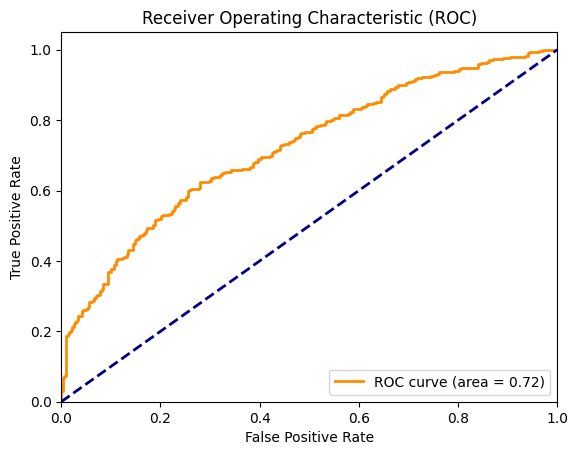

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_tfidf_svd.predict_proba(X_test[svdTfidfFeatures + pcaFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### Word Embeddings

In [ ]:
k = 10
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on Word Embeddings
xgb_model_embed = xgb.XGBClassifier(objective='binary:logistic', max_depth = 3, subsample = 0.8, colsample_bytree = 0.8, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_embed.fit(X_train_fold[embeddingFeatures + metadataFeatures], y_train_fold)

  # Evaluate on the validation set
  y_pred_fold = xgb_model_embed.predict(X_val_fold[embeddingFeatures + metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_embed, X_train[embeddingFeatures + metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfEmbed = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfEmbed)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on full training set
xgb_model_embed.fit(X_train[embeddingFeatures + metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_embed.predict(X_test[embeddingFeatures + metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.6289
Std. Dev: 0.0349
All accuracy values:  [0.602 0.663 0.62  0.657 0.633 0.596 0.559 0.629 0.645 0.686]
Average ROC-AUC: 0.6728
Folds avg. metrics:
      metric    Female      Male
0   f1-score  0.639535  0.616566
1  precision  0.615887  0.645536
2     recall  0.666651  0.591850
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.6515
Classification Report:
               precision    recall  f1-score   support

      Female       0.66      0.68      0.67       318
        Male       0.64      0.62      0.63       296

    accuracy                           0.65       614
   macro avg       0.65      0.65      0.65       614
weighted avg       0.65      0.65      0.65       614

Confusion Matrix:
 [[216 102]
 [112 184]]


In [ ]:
reportsDfEmbed.round(3)

,metric,Female,Male
0,f1-score,0.640,0.617
1,precision,0.616,0.646
2,recall,0.667,0.592


##### ROC

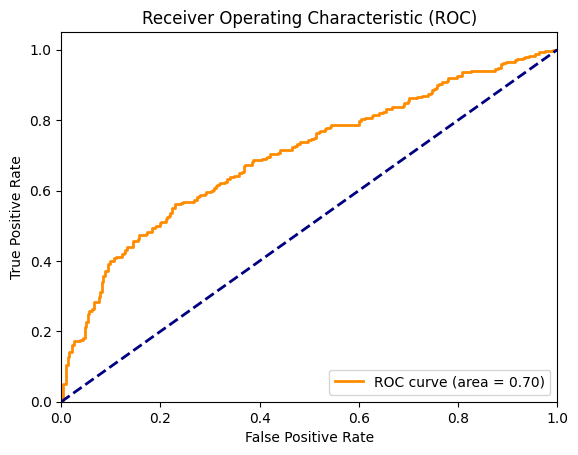

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_embed.predict_proba(X_test[embeddingFeatures + metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Predictions

In [ ]:
# Use the TF-IDF model to infer the gender on the unlabelled data

# Get the data to predict
toPredictDf = authorsWithTextDf[authorsWithTextDf.gender == "Unknown"]
print("Shape of unlabelled data:", toPredictDf.shape)
additionlFeatureName = toPredictDf.drop(columns=["author_id", "cleaned_text", "gender"]).columns.tolist()

# Vectorize
vectPredict = vectorizer.transform(toPredictDf["cleaned_text"])

# use this for TF-IDF
#toPredict = preprocessor.transform(toPredictDf)
#toPredictDf = pd.DataFrame(toPredict, columns = preprocessor.get_feature_names_out())

# use this for TF-IDF + SVD
toPredict = pipeline.transform(toPredictDf)[:, :nComponents]
toPredictDf = pd.DataFrame(toPredict, columns = pcaFeatures, index = toPredictDf.index)

# Combine with the other features
applySVD = True
if applySVD:
  toPredictDf = pd.DataFrame(svd.transform(vectPredict), columns = [f"svd_tfidf_{i}" for i in range(100)], index = toPredictDf.index).join(toPredictDf)
else:
  toPredictDf = pd.DataFrame(vectPredict.toarray(), columns = vectorizer.get_feature_names_out(), index = toPredictDf.index).join(toPredictDf)

# Predict
#y_pred_tfidf = xgb_model_tfidf.predict(toPredictDf)
y_pred_tfidf = xgb_model_tfidf_svd.predict(toPredictDf)

# use the label encoder to decode the result
y_pred_tfidf = le.inverse_transform(y_pred_tfidf)
predictionsDf = pd.DataFrame({"gender": y_pred_tfidf}, index = authorsWithTextDf[authorsWithTextDf.gender == "Unknown"].index)

# Update the Unknown gender on the original dataframe
authorsWithTextDf.loc[authorsWithTextDf.gender == "Unknown", "gender"] = predictionsDf["gender"]

Shape of unlabelled data: (1836, 30)


In [ ]:
# Validate
authorsWithTextDf.groupby("gender")["author_id"].count()

,author_id
gender,
Female,3185
Male,2427


### Save

In [ ]:
# Save the result dataframe to pickle
featureSet = ['author_id', 'verified', 'lexical_density', 'description_len', 'account_age',
                'followers_count', 'following_count', 'tweet_count',
                'fav_posting_time', 'fav_day_of_week', 'mean_time_between_tweets', 'tweet_frequency', 'is_weekend',
                'auth_hashtag_count', 'auth_url_count', 'auth_mention_count', 'auth_like_count', 'auth_retweet_count', 'auth_reply_count', 'auth_quote_count', 'auth_avg_tokens',
                'noun_tags', 'verb_tags', 'adjective_tags', 'adverb_tags', 'other_tags',
                'emoji_count', 'emoji_sentiment',
                'gender']
resultDf = authorsWithTextDf[featureSet]
resultDf.to_pickle(os.path.join(demographicsDir, "authorGender.pickle"))